# Mobile phone usage prediction

> “If you have enough data about me and enough computer power and biological knowledge, you can hack my body, my brain, my life,” 
“You can reach a point where you know me better than I know myself.”
                                                                    **Yuval Noah Harari.**

#### In this notebook, we will use the data set to find the daily usage apps, time spent on every app, users sleep pattern and productivity.

Hypothesis I have made here:
* User does not spend his time more than 11 hours per day.
* The first and last thing the user does is checking his phone.
* if the phone screen locked more than 5 hours, then the user is sleeping.

# Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# settings
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/mobile-usage-dataset-individual-person/phone_usage.csv
/kaggle/input/mobile-usage-dataset-individual-person/Usage_all_apps.csv
/kaggle/input/mobile-usage-dataset-individual-person/CheckDevice.csv


In [2]:
#importing the required library files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
#loading the data 
chk = pd.read_csv('../input/mobile-usage-dataset-individual-person/CheckDevice.csv')
ph_usage = pd.read_csv('../input/mobile-usage-dataset-individual-person/phone_usage.csv')


consists of phone unlocked count and screen on time per day

In [4]:
chk.head()

,Date,Check phone count,Screen on time
0,27/11/2019,30.0,3:17:07
1,26/11/2019,55.0,3:56:09
2,25/11/2019,79.0,5:11:51
3,24/11/2019,68.0,5:07:07
4,23/11/2019,66.0,5:52:24


this data set consists of every app usage's duration and the time opened with date 

In [5]:
ph_usage.head()

,App name,Date,Time,Duration
0,App Usage,26/11/2019,20:06:27,0:01:01
1,Instagram,26/11/2019,20:05:43,0:00:23
2,Gmail,26/11/2019,20:05:02,0:00:35
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00
4,Screen on (locked),26/11/2019,20:05:01,0:00:01


In [6]:
print("info of CHECK COUNT")
print('--'*20)
chk.info()

info of CHECK COUNT
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
Date                 197 non-null object
Check phone count    195 non-null float64
Screen on time       195 non-null object
dtypes: float64(1), object(2)
memory usage: 4.8+ KB


# Data preprocessing

Cleaning the data...


In [7]:
#renaming the columns name
chk.rename(columns={'Check phone count': 'check_phn_count', 'Screen on time': 'screen_on_time'}, inplace=True)

In [8]:
#droping the NaN columns
chk.dropna(axis=0, inplace =True)

Converting the screen time on to minutes 

In [9]:
chk['duration'] = chk['screen_on_time'].str.split(':').apply(lambda x: int(x[0]) *60 + int(x[1])  )

In [10]:
chk.describe()

,check_phn_count,duration
count,195.000000,195.000000
mean,72.410256,4071.174359
std,17.161330,52061.263077
min,19.000000,37.000000
25%,63.000000,279.500000
50%,70.000000,336.000000
75%,81.000000,389.000000
max,158.000000,727337.000000


Duration indicated the minutes used every day. here as a cleaning process, assuming the person does not use 
mobile more 11hrs(660minutes) per day. if it exists 11hours then it is replaced with the median of duration

In [11]:
chk.loc[chk['duration'] > 660, 'duration'] = chk['duration'].median()

In [12]:
chk.describe()

,check_phn_count,duration
count,195.000000,195.000000
mean,72.410256,336.584615
std,17.161330,82.431019
min,19.000000,37.000000
25%,63.000000,279.500000
50%,70.000000,336.000000
75%,81.000000,382.500000
max,158.000000,570.000000


### From the above information, the user unlocks the phone approximately 72 times per day and he uses phone approximately 5.5hrs(336 minutes) per day

In [13]:
chk["Date"]= pd.to_datetime(chk["Date"]) 


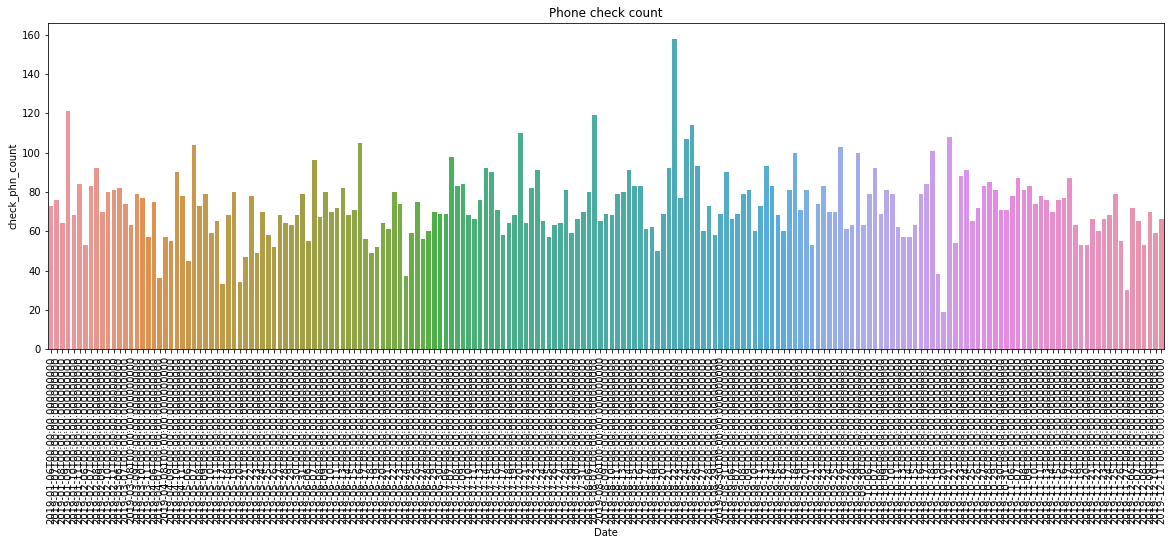

In [14]:
#Bar plot with respect ot date and the phone check count
plt.figure(figsize=(20,6))
sns.barplot(x="Date", y="check_phn_count", data=chk)
plt.title('Phone check count')
plt.xticks(rotation=90)
plt.show()

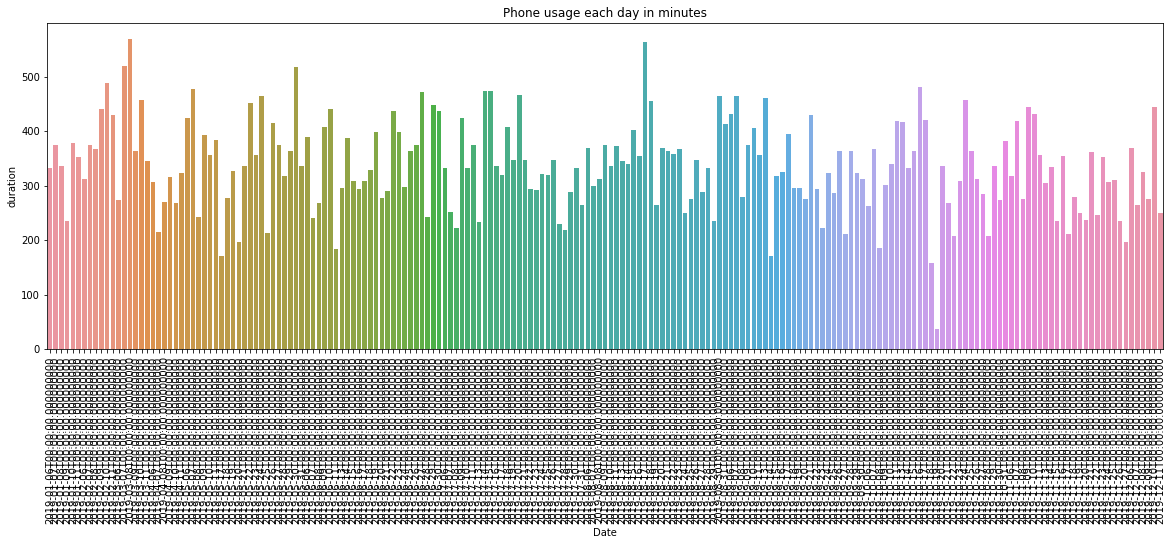

In [15]:
#Bar plot with respect to date and the phone usage duration everyday
plt.figure(figsize=(20,6))
sns.barplot(x="Date", y="duration", data=chk)
plt.title('Phone usage each day in minutes')
plt.xticks(rotation=90)
plt.show()

In [16]:
## converting the date column from object to time series
chk['Date'] = pd.to_datetime(chk['Date'])

In [17]:
chk['day_of_week'] = chk['Date'].dt.dayofweek
chk

,Date,check_phn_count,screen_on_time,duration,day_of_week
0,2019-11-27,30.0,3:17:07,197.0,2
1,2019-11-26,55.0,3:56:09,236.0,1
2,2019-11-25,79.0,5:11:51,311.0,0
3,2019-11-24,68.0,5:07:07,307.0,6
4,2019-11-23,66.0,5:52:24,352.0,5
...,...,...,...,...,...
190,2019-05-21,47.0,12122:17:48,336.0,1
191,2019-05-20,34.0,3:17:24,197.0,0
192,2019-05-19,80.0,5:27:18,327.0,6
193,2019-05-18,68.0,4:37:25,277.0,5


In [18]:
chk.groupby('day_of_week').sum().nlargest(20,'duration').reset_index()

,day_of_week,check_phn_count,duration
0,3,2029.0,10079.0
1,6,2157.0,9956.0
2,4,2012.0,9479.0
3,5,2017.0,9467.0
4,2,2188.0,9101.0
5,0,1957.0,8985.0
6,1,1760.0,8567.0


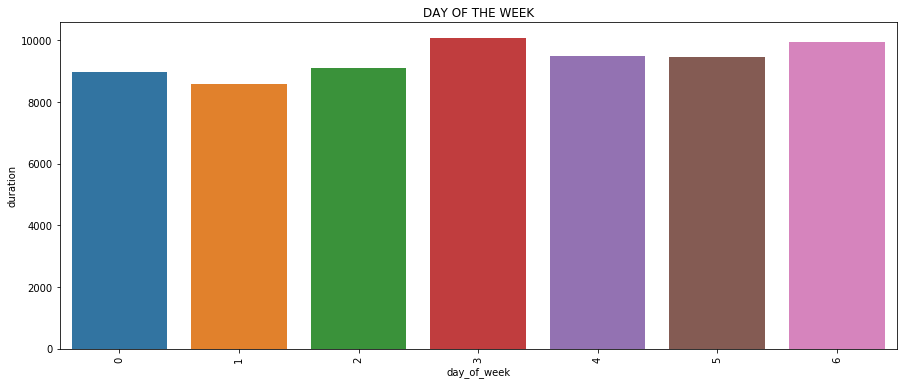

In [19]:
plt.figure(figsize=(15,6))
data = chk.groupby('day_of_week').sum().nlargest(20,'duration').reset_index()
sns.barplot(x='day_of_week',y='duration',data=data)
plt.title('DAY OF THE WEEK')
plt.xticks(rotation=90)
plt.show()

### the above plot is the comparison of day of week with the duration. the user uses his phone in same pattern on all day. there is slightly high usage of his phone on wednesday and saturday.

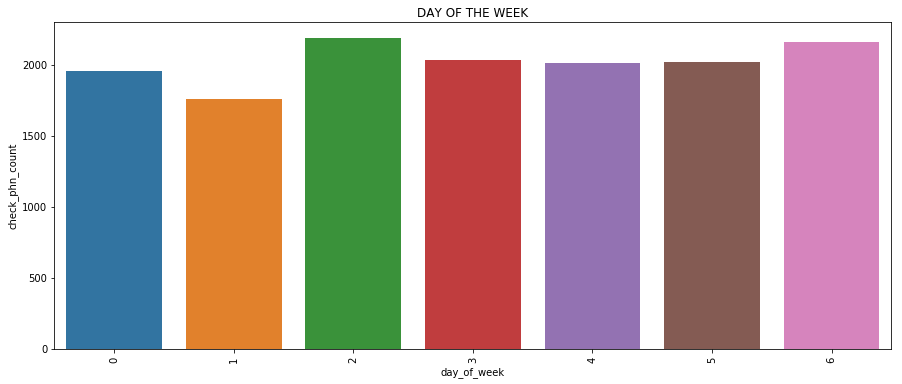

In [20]:
plt.figure(figsize=(15,6))
data = chk.groupby('day_of_week').sum().nlargest(20,'check_phn_count').reset_index()
sns.barplot(x='day_of_week',y='check_phn_count',data=data)
plt.title('DAY OF THE WEEK')
plt.xticks(rotation=90)
plt.show()

### the above plot is the comparison of day of week with the phone unlock. the user uses his phone in same pattern on all day of week. there is slightly high unlock found on tuesday and saturday.

In [21]:
chk['categories'] = chk['day_of_week'].apply(lambda x: 'weekday' if x < 5 else 'weekend')

chk['weekday'] = chk['categories'].apply(lambda x: '0' if x == 'weekday' else '1')
chk.drop(columns='categories', inplace=True)
chk

,Date,check_phn_count,screen_on_time,duration,day_of_week,weekday
0,2019-11-27,30.0,3:17:07,197.0,2,0
1,2019-11-26,55.0,3:56:09,236.0,1,0
2,2019-11-25,79.0,5:11:51,311.0,0,0
3,2019-11-24,68.0,5:07:07,307.0,6,1
4,2019-11-23,66.0,5:52:24,352.0,5,1
...,...,...,...,...,...,...
190,2019-05-21,47.0,12122:17:48,336.0,1,0
191,2019-05-20,34.0,3:17:24,197.0,0,0
192,2019-05-19,80.0,5:27:18,327.0,6,1
193,2019-05-18,68.0,4:37:25,277.0,5,1


In [22]:
chk['month'] = pd.DatetimeIndex(chk['Date']).month
chk.head()

,Date,check_phn_count,screen_on_time,duration,day_of_week,weekday,month
0,2019-11-27,30.0,3:17:07,197.0,2,0,11
1,2019-11-26,55.0,3:56:09,236.0,1,0,11
2,2019-11-25,79.0,5:11:51,311.0,0,0,11
3,2019-11-24,68.0,5:07:07,307.0,6,1,11
4,2019-11-23,66.0,5:52:24,352.0,5,1,11


#### Loading the next data set

In [23]:
ph_usage.head(10)

,App name,Date,Time,Duration
0,App Usage,26/11/2019,20:06:27,0:01:01
1,Instagram,26/11/2019,20:05:43,0:00:23
2,Gmail,26/11/2019,20:05:02,0:00:35
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00
4,Screen on (locked),26/11/2019,20:05:01,0:00:01
5,Screen off (locked),26/11/2019,20:01:11,0:03:50
6,Gmail,26/11/2019,20:00:43,0:00:28
7,Gallery,26/11/2019,20:00:31,0:00:09
8,Gmail,26/11/2019,19:59:26,0:01:05
9,Gallery,26/11/2019,19:59:24,0:00:01


In [24]:
#renaming the columns name
ph_usage.rename(columns={'App name': 'App_name'}, inplace=True)

In [25]:
ph_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90719 entries, 0 to 90718
Data columns (total 4 columns):
App_name    90718 non-null object
Date        90716 non-null object
Time        90716 non-null object
Duration    90716 non-null object
dtypes: object(4)
memory usage: 2.8+ MB


In [26]:
ph_usage.describe()

,App_name,Date,Time,Duration
count,90718,90716,90716,90716
unique,160,194,47643,2572
top,Screen on (locked),22/08/2019,00:00:00,0:00:01
freq,18211,907,28,14697


In [27]:
ph_usage.shape

(90719, 4)

In [28]:
#droping the NaN columns
ph_usage.dropna(axis=0, inplace =True)

In [29]:
ph_usage.columns

Index(['App_name', 'Date', 'Time', 'Duration'], dtype='object')

In [30]:
#making a new copy of data frame
ph_usg = ph_usage

In [31]:
# Creating a new column of datetime (timestamp)
ph_usg['DateTime']= pd.to_datetime(ph_usg['Date'] +" " + ph_usg['Time'],format='%d/%m/%Y %H:%M:%S')
ph_usg.head()

,App_name,Date,Time,Duration,DateTime
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27
1,Instagram,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43
2,Gmail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00,2019-11-26 20:05:02
4,Screen on (locked),26/11/2019,20:05:01,0:00:01,2019-11-26 20:05:01


In [32]:
# Converting the duration into seconds.
ph_usg['usage_seconds'] = ph_usg['Duration'].str.split(':').apply(lambda x: int(x[0]) *3600 + int(x[1]) * 60 + int(x[2]))
ph_usg

,App_name,Date,Time,Duration,DateTime,usage_seconds
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61
1,Instagram,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23
2,Gmail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00,2019-11-26 20:05:02,0
4,Screen on (locked),26/11/2019,20:05:01,0:00:01,2019-11-26 20:05:01,1
...,...,...,...,...,...,...
90711,Settings,17/05/2019,18:28:30,0:00:03,2019-05-17 18:28:30,3
90712,Screen on (unlocked),17/05/2019,18:28:29,0:00:01,2019-05-17 18:28:29,1
90713,Screen off (locked),17/05/2019,18:25:10,0:03:19,2019-05-17 18:25:10,199
90714,Screen on (unlocked),17/05/2019,18:25:10,0:00:01,2019-05-17 18:25:10,1


In [33]:
# to find the number of days
ph_usg['DateTime'].max() - ph_usg['DateTime'].min()

Timedelta('193 days 01:41:20')

In [34]:
#Filtering the system apps and system usage
system_tracker = ['Screen on (unlocked)','Screen off (locked)','Screen on (locked)', 'Screen off','Permission controller','System UI','Package installer',
'Device shutdown','Call Management']
service_app = ph_usg[ph_usg['App_name'].isin(system_tracker)]
service_app

,App_name,Date,Time,Duration,DateTime,usage_seconds
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00,2019-11-26 20:05:02,0
4,Screen on (locked),26/11/2019,20:05:01,0:00:01,2019-11-26 20:05:01,1
5,Screen off (locked),26/11/2019,20:01:11,0:03:50,2019-11-26 20:01:11,230
10,Screen on (unlocked),26/11/2019,19:58:44,0:00:00,2019-11-26 19:58:44,0
11,Screen on (locked),26/11/2019,19:58:43,0:00:01,2019-11-26 19:58:43,1
...,...,...,...,...,...,...
90710,Screen off (locked),17/05/2019,18:28:33,0:00:02,2019-05-17 18:28:33,2
90712,Screen on (unlocked),17/05/2019,18:28:29,0:00:01,2019-05-17 18:28:29,1
90713,Screen off (locked),17/05/2019,18:25:10,0:03:19,2019-05-17 18:25:10,199
90714,Screen on (unlocked),17/05/2019,18:25:10,0:00:01,2019-05-17 18:25:10,1


In [35]:
#Getting all the user apps.
all_apps = ph_usg[~ph_usg['App_name'].isin(system_tracker)]

all_apps

,App_name,Date,Time,Duration,DateTime,usage_seconds
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61
1,Instagram,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23
2,Gmail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35
6,Gmail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28
7,Gallery,26/11/2019,20:00:31,0:00:09,2019-11-26 20:00:31,9
...,...,...,...,...,...,...
90695,Contacts,17/05/2019,18:42:24,0:00:04,2019-05-17 18:42:24,4
90698,MTP application,17/05/2019,18:30:28,0:00:02,2019-05-17 18:30:28,2
90701,MTP application,17/05/2019,18:30:24,0:00:00,2019-05-17 18:30:24,0
90706,Settings,17/05/2019,18:30:17,0:00:03,2019-05-17 18:30:17,3


In [36]:
#sorting the usage seconds in descending order
test = service_app.sort_values(by='usage_seconds',ascending=0)


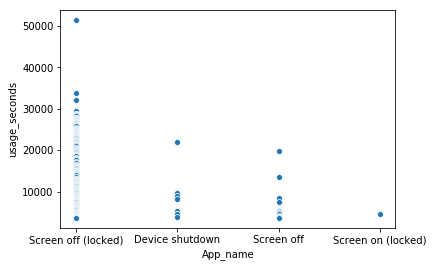

In [37]:
sns.scatterplot(x='App_name', y='usage_seconds', data=test[test['usage_seconds'] > 3600])

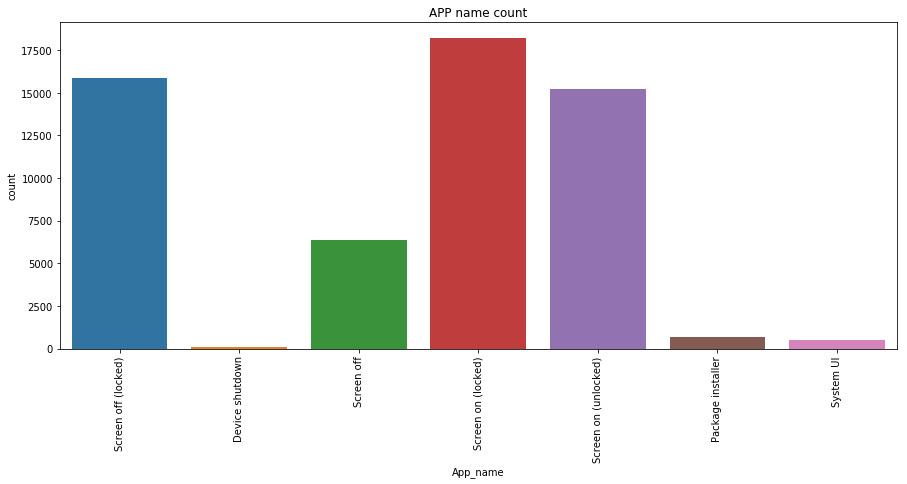

In [38]:
plt.figure(figsize=(15,6))
sns.countplot(test['App_name'])
plt.title('APP name count')
plt.xticks(rotation=90)
plt.show()

In [39]:
sleep = ['Screen off (locked)','Screen on (locked)', 'Screen off']
sleep_duration = service_app[service_app['App_name'].isin(sleep)]
sleep_duration

,App_name,Date,Time,Duration,DateTime,usage_seconds
4,Screen on (locked),26/11/2019,20:05:01,0:00:01,2019-11-26 20:05:01,1
5,Screen off (locked),26/11/2019,20:01:11,0:03:50,2019-11-26 20:01:11,230
11,Screen on (locked),26/11/2019,19:58:43,0:00:01,2019-11-26 19:58:43,1
12,Screen off (locked),26/11/2019,19:32:25,0:26:18,2019-11-26 19:32:25,1578
15,Screen off,26/11/2019,19:17:24,0:13:51,2019-11-26 19:17:24,831
...,...,...,...,...,...,...
90705,Screen off (locked),17/05/2019,18:30:20,0:00:02,2019-05-17 18:30:20,2
90708,Screen off (locked),17/05/2019,18:28:35,0:01:41,2019-05-17 18:28:35,101
90710,Screen off (locked),17/05/2019,18:28:33,0:00:02,2019-05-17 18:28:33,2
90713,Screen off (locked),17/05/2019,18:25:10,0:03:19,2019-05-17 18:25:10,199


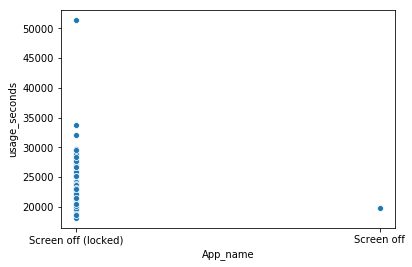

In [40]:
sns.scatterplot(x='App_name', y='usage_seconds', data=sleep_duration[sleep_duration['usage_seconds'] > 18000])

In [41]:
new = sleep_duration[sleep_duration['usage_seconds'] > 18000]
new

,App_name,Date,Time,Duration,DateTime,usage_seconds
759,Screen off (locked),25/11/2019,00:02:41,5:13:29,2019-11-25 00:02:41,18809
1562,Screen off (locked),22/11/2019,23:25:14,5:10:28,2019-11-22 23:25:14,18628
2433,Screen off (locked),21/11/2019,00:01:42,6:26:20,2019-11-21 00:01:42,23180
2710,Screen off (locked),20/11/2019,00:13:23,5:42:59,2019-11-20 00:13:23,20579
3011,Screen off (locked),18/11/2019,23:40:44,7:14:19,2019-11-18 23:40:44,26059
...,...,...,...,...,...,...
86973,Screen off (locked),26/05/2019,00:29:14,6:26:47,2019-05-26 00:29:14,23207
87336,Screen off (locked),25/05/2019,00:06:22,5:58:41,2019-05-25 00:06:22,21521
87738,Screen off (locked),24/05/2019,00:23:15,5:41:46,2019-05-24 00:23:15,20506
88116,Screen off (locked),22/05/2019,23:38:06,6:23:37,2019-05-22 23:38:06,23017


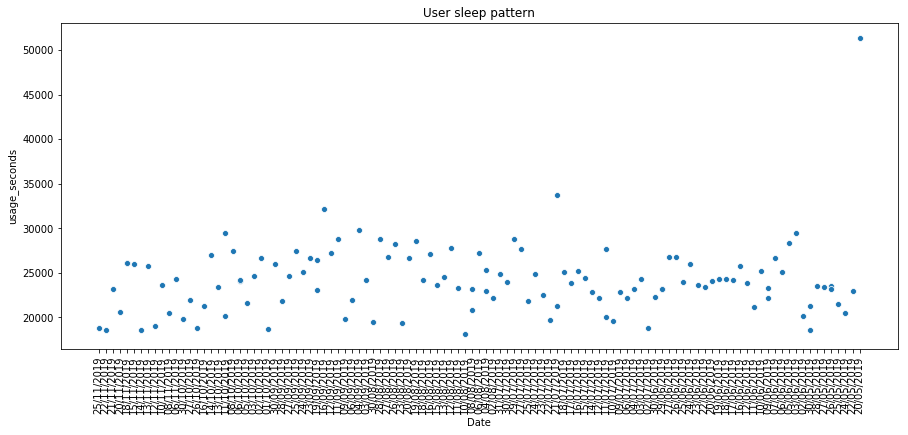

In [42]:

plt.figure(figsize=(15,6))
sns.scatterplot(x='Date', y='usage_seconds', data=new)
plt.title('User sleep pattern')
plt.xticks(rotation=90)
plt.show()

In [43]:
#The user approximately sleeps 6.7 hours everyday.. since the screen off was filtered more than 5 hours. all the time are showing around 10PM to 1AM
new.usage_seconds.mean()

24159.73553719008

### The user approximately sleeps 6.7 hours every day.. 
#### since the screen off was filtered more than 5 hours. all the time are showing around 11PM to 1AM

### if the user sleeps around 11PM to 1AM and his sleeping hours approximately 7 hours, then obviously he will wake up by 6AM to 8AM


In [44]:
# Getting the screen on unlocked alone
wake = ['Screen on (unlocked)']
wake_up = service_app[service_app['App_name'].isin(wake)]
wake_up.head()

,App_name,Date,Time,Duration,DateTime,usage_seconds
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00,2019-11-26 20:05:02,0
10,Screen on (unlocked),26/11/2019,19:58:44,0:00:00,2019-11-26 19:58:44,0
14,Screen on (unlocked),26/11/2019,19:31:14,0:00:01,2019-11-26 19:31:14,1
21,Screen on (unlocked),26/11/2019,19:11:15,0:00:01,2019-11-26 19:11:15,1
44,Screen on (unlocked),26/11/2019,18:59:34,0:00:00,2019-11-26 18:59:34,0


In [45]:
wake_up.tail()

,App_name,Date,Time,Duration,DateTime,usage_seconds
90704,Screen on (unlocked),17/05/2019,18:30:22,0:00:01,2019-05-17 18:30:22,1
90707,Screen on (unlocked),17/05/2019,18:30:17,0:00:01,2019-05-17 18:30:17,1
90709,Screen on (unlocked),17/05/2019,18:28:35,0:00:01,2019-05-17 18:28:35,1
90712,Screen on (unlocked),17/05/2019,18:28:29,0:00:01,2019-05-17 18:28:29,1
90714,Screen on (unlocked),17/05/2019,18:25:10,0:00:01,2019-05-17 18:25:10,1


In [46]:
#Grouping the datetime on the basis of frequency day and getting the minimum time of the day
wakeup_time= wake_up.set_index('DateTime').groupby(pd.Grouper(freq='D')).min()
wakeup_time.tail(50)


,App_name,Date,Time,Duration,usage_seconds
DateTime,,,,,
2019-10-08,Screen on (unlocked),08/10/2019,01:04:21,0:00:00,0
2019-10-09,Screen on (unlocked),09/10/2019,06:21:28,0:00:00,0
2019-10-10,Screen on (unlocked),10/10/2019,05:56:52,0:00:00,0
2019-10-11,Screen on (unlocked),11/10/2019,06:15:21,0:00:00,0
2019-10-12,Screen on (unlocked),12/10/2019,06:50:02,0:00:00,0
2019-10-13,Screen on (unlocked),13/10/2019,04:08:11,0:00:00,0
2019-10-14,Screen on (unlocked),14/10/2019,05:48:29,0:00:00,0
2019-10-15,Screen on (unlocked),15/10/2019,06:02:08,0:00:00,0
2019-10-16,Screen on (unlocked),16/10/2019,02:02:20,0:00:00,0


### This clearly shows that the user wakeup around 6AM to 8AM. On very few days he wakeup between 2AM to 3AM. he had a good sleep.

In [47]:
#Filtering the app usage seconds more than 10 seconds. Assuming that user use apps more than 10 seconds. 
all_apps = all_apps[(all_apps.usage_seconds > 10)]
all_apps

,App_name,Date,Time,Duration,DateTime,usage_seconds
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61
1,Instagram,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23
2,Gmail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35
6,Gmail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28
8,Gmail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,65
...,...,...,...,...,...,...
90661,WhatsApp,17/05/2019,19:06:43,0:00:23,2019-05-17 19:06:43,23
90665,WhatsApp,17/05/2019,19:05:29,0:00:22,2019-05-17 19:05:29,22
90667,Messages,17/05/2019,19:04:19,0:00:43,2019-05-17 19:04:19,43
90675,SIM card manager,17/05/2019,18:44:40,0:00:12,2019-05-17 18:44:40,12


In [48]:
#All apps access count
all_apps['App_name'].value_counts()

Instagram          5370
WhatsApp           5323
Phone              3054
YouTube            1077
Chrome              972
                   ... 
DeviceKeystring       1
SimpleMind Free       1
AppCloud              1
Orbot                 1
Lens                  1
Name: App_name, Length: 133, dtype: int64

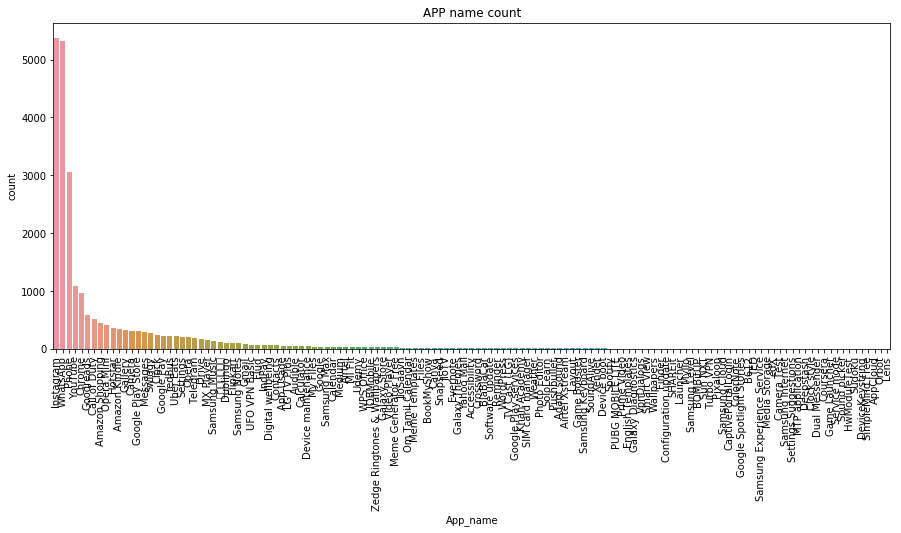

In [49]:
plt.figure(figsize=(15,6))
sns.countplot(x = 'App_name',
              data = all_apps,
              order = all_apps['App_name'].value_counts().index)

plt.title('APP name count')
plt.xticks(rotation=90)
plt.show()

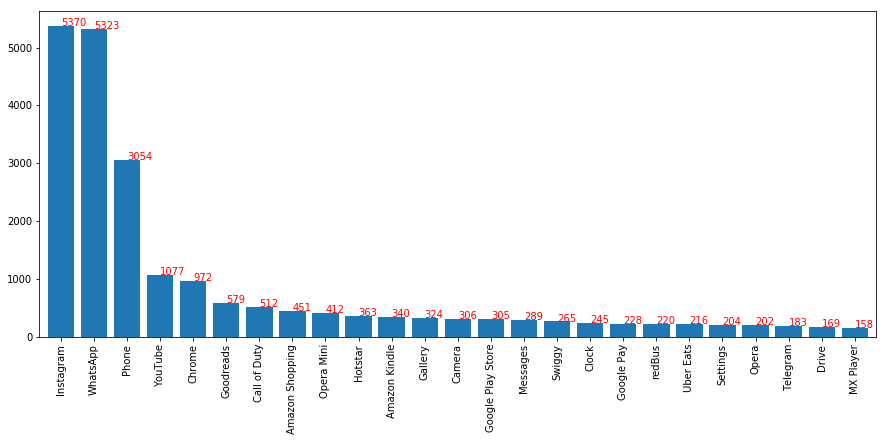

In [50]:
plt.figure(figsize=(15,6))
s = all_apps['App_name'].value_counts().head(25)
ax= s.plot.bar(width=.8) 

for i, v in s.reset_index().iterrows():
    ax.text(i, v.App_name + 0.2 , v.App_name, color='red')

### The above plot shows the user's access count of the top 25 apps. 
### Instagram was accessed 5370 times, whatsapp 5323 times. It shows that the user spends most of his time on social media.

In [51]:
all_apps['usage_minutes'] = all_apps['usage_seconds']//60


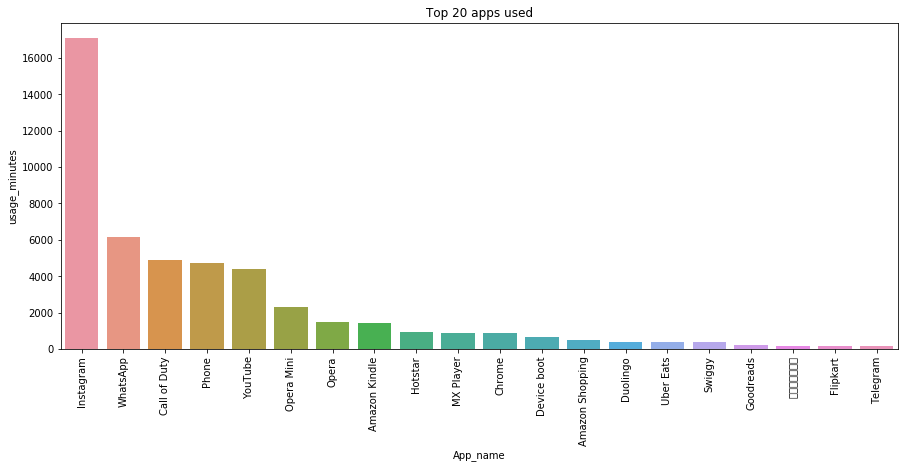

In [52]:
plt.figure(figsize=(15,6))
data = all_apps.groupby('App_name').sum().nlargest(20,'usage_minutes').reset_index()
sns.barplot(x='App_name',y='usage_minutes',data=data)
plt.title('Top 20 apps used')
plt.xticks(rotation=90)
plt.show()

In [53]:
all_apps.groupby('App_name').sum().nlargest(20,'usage_minutes').reset_index()

,App_name,usage_seconds,usage_minutes
0,Instagram,1179594,17079
1,WhatsApp,517189,6134
2,Call of Duty,306699,4861
3,Phone,371189,4727
4,YouTube,294568,4395
5,Opera Mini,151866,2326
6,Opera,94007,1477
7,Amazon Kindle,94730,1407
8,Hotstar,67037,948
9,MX Player,57697,888


### user spends most of his time in instagram 17079 minutes which is 284 hours (12 days)
### out of 193 days he spends 12 days in instagram alone.
#### This seems very huge time, but on average he spends 1.5 hours on social media.


In [54]:
def dateFeatures(all_apps):
    features = ['day','week','dayofweek','month','weekofyear']
    for col in features:
        all_apps[col] = getattr(all_apps['DateTime'].dt,col) * 1

In [55]:
dateFeatures(all_apps)
all_apps

,App_name,Date,Time,Duration,DateTime,usage_seconds,usage_minutes,day,week,dayofweek,month,weekofyear
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61,1,26,48,1,11,48
1,Instagram,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23,0,26,48,1,11,48
2,Gmail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35,0,26,48,1,11,48
6,Gmail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28,0,26,48,1,11,48
8,Gmail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,65,1,26,48,1,11,48
...,...,...,...,...,...,...,...,...,...,...,...,...
90661,WhatsApp,17/05/2019,19:06:43,0:00:23,2019-05-17 19:06:43,23,0,17,20,4,5,20
90665,WhatsApp,17/05/2019,19:05:29,0:00:22,2019-05-17 19:05:29,22,0,17,20,4,5,20
90667,Messages,17/05/2019,19:04:19,0:00:43,2019-05-17 19:04:19,43,0,17,20,4,5,20
90675,SIM card manager,17/05/2019,18:44:40,0:00:12,2019-05-17 18:44:40,12,0,17,20,4,5,20


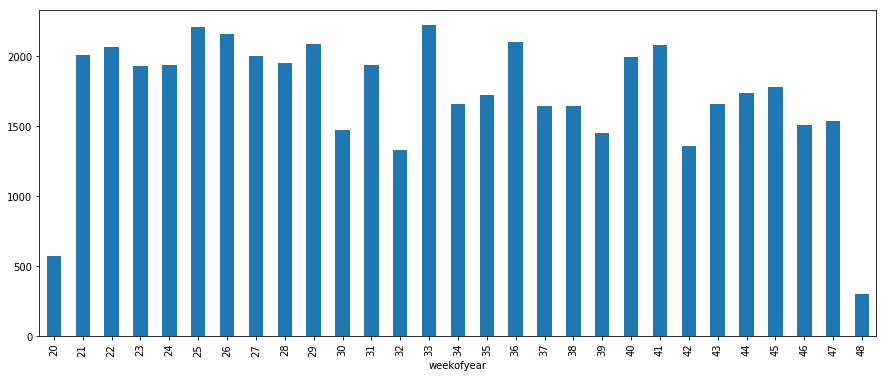

In [56]:
plt.figure(figsize=(15,6))
all_apps.groupby(['weekofyear'])['usage_minutes'].sum().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

### The above plot shows the total usage time for every week. week 20 and 48 shows low usage but there is shortage of data on those weeks.

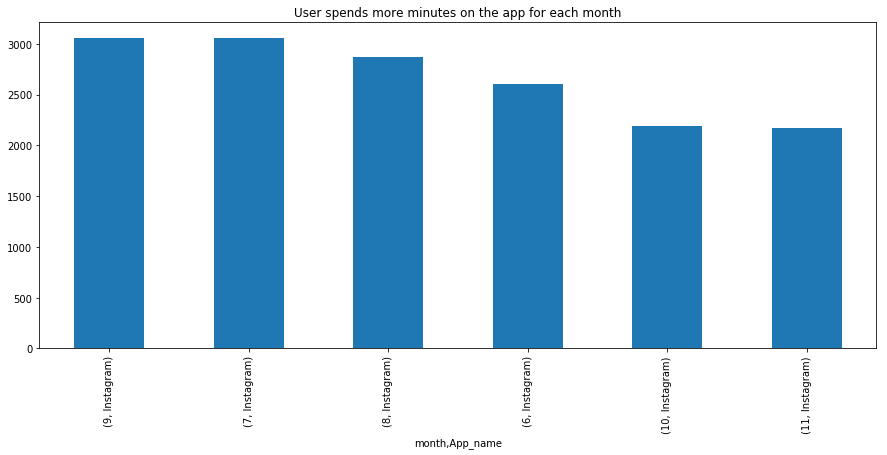

In [57]:
plt.figure(figsize=(15,6))
all_apps.groupby(['month','App_name']).sum().nlargest(6,'usage_minutes')['usage_minutes'].plot(kind='bar')
plt.title('User spends more minutes on the app for each month')
plt.xticks(rotation=90)
plt.show()

### The above plot shows the total usage time for every month with respect most time spent app.
### the user used instagram every month at higher amount

In [58]:
all_apps

,App_name,Date,Time,Duration,DateTime,usage_seconds,usage_minutes,day,week,dayofweek,month,weekofyear
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61,1,26,48,1,11,48
1,Instagram,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23,0,26,48,1,11,48
2,Gmail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35,0,26,48,1,11,48
6,Gmail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28,0,26,48,1,11,48
8,Gmail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,65,1,26,48,1,11,48
...,...,...,...,...,...,...,...,...,...,...,...,...
90661,WhatsApp,17/05/2019,19:06:43,0:00:23,2019-05-17 19:06:43,23,0,17,20,4,5,20
90665,WhatsApp,17/05/2019,19:05:29,0:00:22,2019-05-17 19:05:29,22,0,17,20,4,5,20
90667,Messages,17/05/2019,19:04:19,0:00:43,2019-05-17 19:04:19,43,0,17,20,4,5,20
90675,SIM card manager,17/05/2019,18:44:40,0:00:12,2019-05-17 18:44:40,12,0,17,20,4,5,20


In [59]:
train = all_apps.copy()

In [60]:
def f(x):
    if (x > 5) and (x <= 8):
        return 'Early_Morn'
    elif (x > 8) and (x <= 12 ):
        return 'Morn'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late_Night'

In [61]:
# make a session
train['hour'] = train['DateTime'].dt.hour
train['session'] = train['hour'].apply(f)
train.drop(['weekofyear','usage_seconds'],axis=1, inplace=True)

In [62]:
train

,App_name,Date,Time,Duration,DateTime,usage_minutes,day,week,dayofweek,month,hour,session
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,1,26,48,1,11,20,Eve
1,Instagram,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,0,26,48,1,11,20,Eve
2,Gmail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,0,26,48,1,11,20,Eve
6,Gmail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,0,26,48,1,11,20,Eve
8,Gmail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,1,26,48,1,11,19,Eve
...,...,...,...,...,...,...,...,...,...,...,...,...
90661,WhatsApp,17/05/2019,19:06:43,0:00:23,2019-05-17 19:06:43,0,17,20,4,5,19,Eve
90665,WhatsApp,17/05/2019,19:05:29,0:00:22,2019-05-17 19:05:29,0,17,20,4,5,19,Eve
90667,Messages,17/05/2019,19:04:19,0:00:43,2019-05-17 19:04:19,0,17,20,4,5,19,Eve
90675,SIM card manager,17/05/2019,18:44:40,0:00:12,2019-05-17 18:44:40,0,17,20,4,5,18,Eve


In [63]:
# Grouping based on the session, date and app name, to find out which counts of app on each session each day
train.groupby(['session','Date','App_name']).size().reset_index()


,session,Date,App_name,0
0,Early_Morn,01/06/2019,Call of Duty,1
1,Early_Morn,01/06/2019,Clock,2
2,Early_Morn,01/06/2019,Instagram,2
3,Early_Morn,01/06/2019,Phone,1
4,Early_Morn,01/06/2019,Samsung Music,6
...,...,...,...,...
7527,Noon,31/08/2019,YouTube,2
7528,Noon,31/10/2019,Camera,1
7529,Noon,31/10/2019,Instagram,4
7530,Noon,31/10/2019,Phone,3


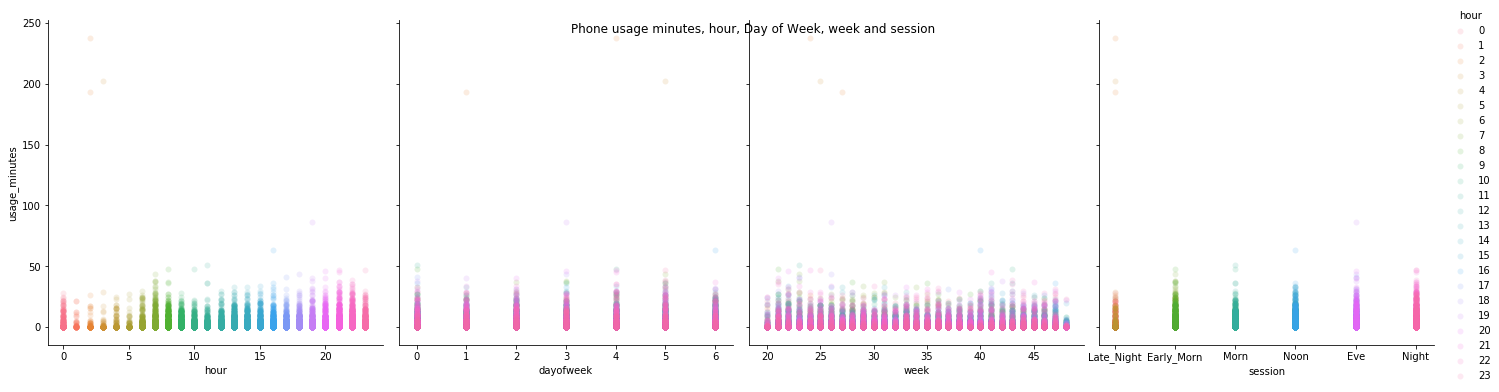

In [64]:
sns.pairplot(train,
             hue='hour',
             x_vars=['hour','dayofweek','week','session'],
             y_vars='usage_minutes',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Phone usage minutes, hour, Day of Week, week and session')
plt.show()

In [65]:
train.set_index('DateTime',inplace=True)

In [66]:
train

,App_name,Date,Time,Duration,usage_minutes,day,week,dayofweek,month,hour,session
DateTime,,,,,,,,,,,
2019-11-26 20:06:27,App Usage,26/11/2019,20:06:27,0:01:01,1,26,48,1,11,20,Eve
2019-11-26 20:05:43,Instagram,26/11/2019,20:05:43,0:00:23,0,26,48,1,11,20,Eve
2019-11-26 20:05:02,Gmail,26/11/2019,20:05:02,0:00:35,0,26,48,1,11,20,Eve
2019-11-26 20:00:43,Gmail,26/11/2019,20:00:43,0:00:28,0,26,48,1,11,20,Eve
2019-11-26 19:59:26,Gmail,26/11/2019,19:59:26,0:01:05,1,26,48,1,11,19,Eve
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-17 19:06:43,WhatsApp,17/05/2019,19:06:43,0:00:23,0,17,20,4,5,19,Eve
2019-05-17 19:05:29,WhatsApp,17/05/2019,19:05:29,0:00:22,0,17,20,4,5,19,Eve
2019-05-17 19:04:19,Messages,17/05/2019,19:04:19,0:00:43,0,17,20,4,5,19,Eve


# Train/Test Split

In [67]:
split_date = '30/10/2019'
f_train = train.loc[train.index <= split_date].copy()
f_test  = train.loc[train.index > split_date].copy()

In [68]:
f_train

,App_name,Date,Time,Duration,usage_minutes,day,week,dayofweek,month,hour,session
DateTime,,,,,,,,,,,
2019-10-29 23:38:10,Instagram,29/10/2019,23:38:10,0:00:15,0,29,44,1,10,23,Night
2019-10-29 23:30:44,Instagram,29/10/2019,23:30:44,0:07:22,7,29,44,1,10,23,Night
2019-10-29 23:28:34,Phone,29/10/2019,23:28:34,0:00:27,0,29,44,1,10,23,Night
2019-10-29 23:26:31,Settings,29/10/2019,23:26:31,0:00:27,0,29,44,1,10,23,Night
2019-10-29 23:24:30,Digital wellbeing,29/10/2019,23:24:30,0:02:02,2,29,44,1,10,23,Night
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-17 19:06:43,WhatsApp,17/05/2019,19:06:43,0:00:23,0,17,20,4,5,19,Eve
2019-05-17 19:05:29,WhatsApp,17/05/2019,19:05:29,0:00:22,0,17,20,4,5,19,Eve
2019-05-17 19:04:19,Messages,17/05/2019,19:04:19,0:00:43,0,17,20,4,5,19,Eve


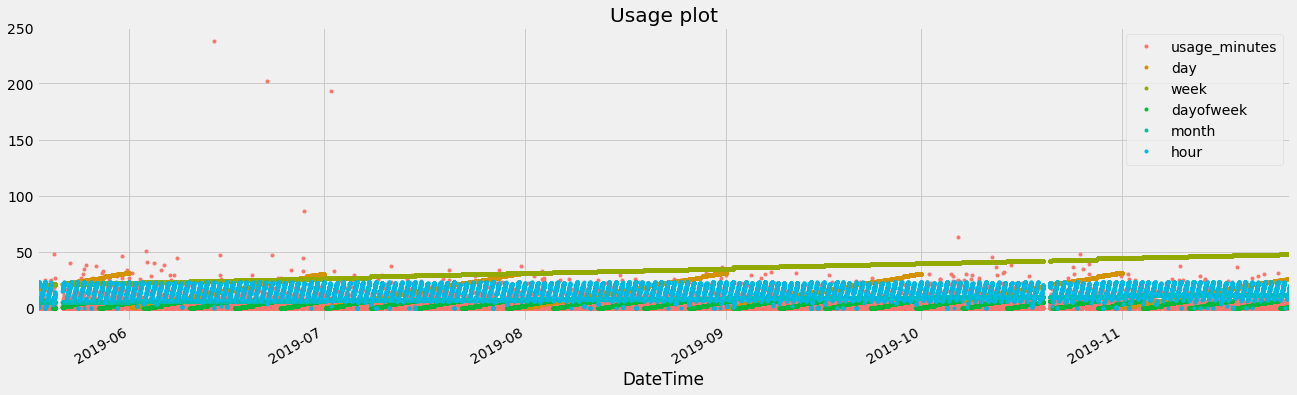

In [69]:
plt.style.use('fivethirtyeight') # For plots
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
train.plot(style='.', figsize=(20,6), color=color_pal, title='Usage plot')
plt.show()

In [70]:
# Format data for prophet model using ds and y
f_train.reset_index().rename(columns={'DateTime':'ds','usage_minutes':'y'}).head()

,ds,App_name,Date,Time,Duration,y,day,week,dayofweek,month,hour,session
0,2019-10-29 23:38:10,Instagram,29/10/2019,23:38:10,0:00:15,0,29,44,1,10,23,Night
1,2019-10-29 23:30:44,Instagram,29/10/2019,23:30:44,0:07:22,7,29,44,1,10,23,Night
2,2019-10-29 23:28:34,Phone,29/10/2019,23:28:34,0:00:27,0,29,44,1,10,23,Night
3,2019-10-29 23:26:31,Settings,29/10/2019,23:26:31,0:00:27,0,29,44,1,10,23,Night
4,2019-10-29 23:24:30,Digital wellbeing,29/10/2019,23:24:30,0:02:02,2,29,44,1,10,23,Night


In [71]:
# Setup and train model and fit
model = Prophet()
model.fit(f_train.reset_index().rename(columns={'DateTime':'ds','usage_minutes':'y'}))

In [72]:
# Predict on training set with model
f_test_fcst = model.predict(df=f_test.reset_index().rename(columns={'DateTime':'ds'}))

In [73]:
f_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-10-30 07:16:21,2.446913,-3.353134,8.419005,2.446913,2.446913,0.233993,0.233993,0.233993,0.307928,0.307928,0.307928,-0.073934,-0.073934,-0.073934,0.0,0.0,0.0,2.680906
1,2019-10-30 07:39:29,2.446883,-2.829962,8.978867,2.446883,2.446883,0.267911,0.267911,0.267911,0.340143,0.340143,0.340143,-0.072232,-0.072232,-0.072232,0.0,0.0,0.0,2.714793
2,2019-10-30 08:38:12,2.446806,-3.611792,8.742530,2.446806,2.446806,0.090956,0.090956,0.090956,0.157835,0.157835,0.157835,-0.066880,-0.066880,-0.066880,0.0,0.0,0.0,2.537762
3,2019-10-30 08:51:39,2.446789,-3.626842,9.066215,2.446789,2.446789,-0.016088,-0.016088,-0.016088,0.049361,0.049361,0.049361,-0.065448,-0.065448,-0.065448,0.0,0.0,0.0,2.430701
4,2019-10-30 08:58:59,2.446779,-3.534042,8.180366,2.446779,2.446779,-0.084169,-0.084169,-0.084169,-0.019533,-0.019533,-0.019533,-0.064636,-0.064636,-0.064636,0.0,0.0,0.0,2.362610


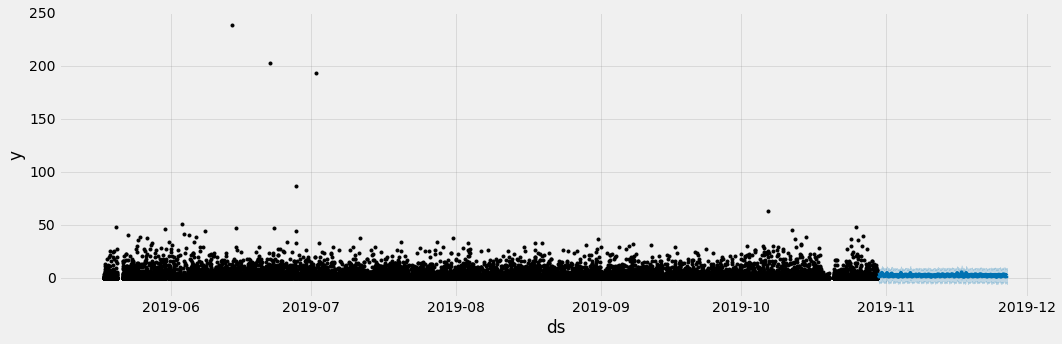

In [74]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(f_test_fcst,ax=ax)
plt.show()

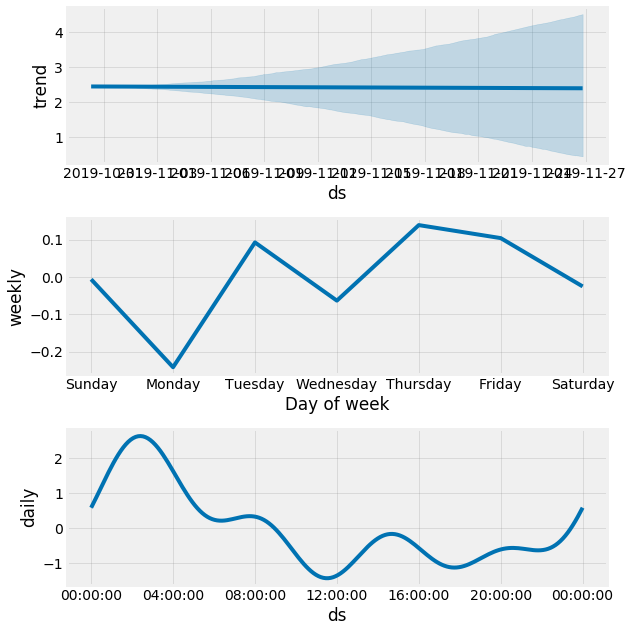

In [75]:
# Plot the components of the model
fig = model.plot_components(f_test_fcst)

    Compare to actual forecast

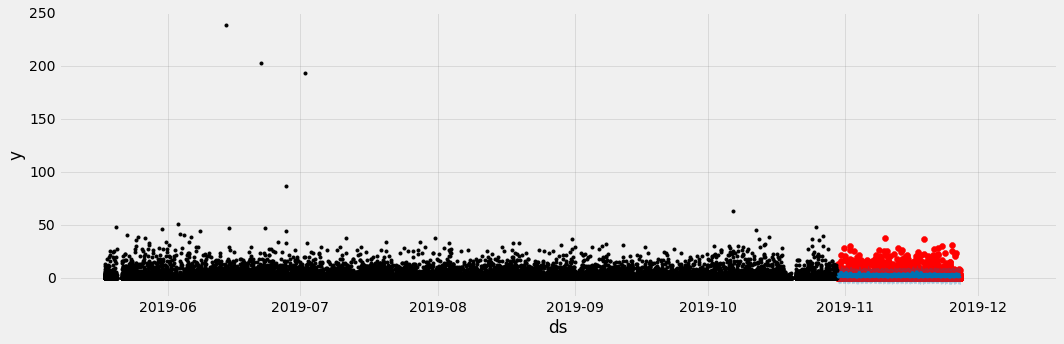

In [76]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(f_test.index, f_test['usage_minutes'], color='r')
fig = model.plot(f_test_fcst, ax=ax)

In [77]:
mean_squared_error(y_true=f_test['usage_minutes'],
                   y_pred=f_test_fcst['yhat'])

16.734254212388095

In [78]:
mean_absolute_error(y_true=f_test['usage_minutes'],
                   y_pred=f_test_fcst['yhat'])

2.4304509792283606

### Need to update the model. prediction is very poor
## need to work with XGBoost

# Conclusion

### * User unlocks the phone approximately 72 times per day and he uses phone approximately 5.5hrs(336 minutes) per day.
### * On average user spends 5.5 hours per day, that means out of 193 days he spends 40 days in phone alone. (very shocking)
### * User uses his phone in the same pattern on all day. there is slightly high usage of his phone on wednesday and saturday.
### * User unlocks his phone in the same pattern on all day of week. there is slightly high unlock found on tuesday and saturday.
### * He approximately sleeps 6.7 hours every day.he had a good sleep.
### * User sleeping time around 11PM to 1AM.
### * Wake up time around 6AM to 8AM. (On very few day user wakeups between 2AM to 3AM.)
### * Instagram was accessed 5370 times, whatsapp 5323 times. It shows that the user spends most of his time on  social media. on average user accesssed instagram and whatsapp ~27times/day. 
### * User accessed instagram and whatsapp on a frequency of every 45 minutes.
### * He spends most of his time in instagram 17079 minutes which is 284 hours (12 days)
### * out of 193 days he spends 12 days in instagram alone. (This seems very huge time, but on average he spends 1.5 hours on social media)



## Things to do for user to improve his productivity

### * User has to set the time limiter for social media apps. Currently, user spends 1.5 hours every day on social media. if he limits to 1 hour per day. then the user can save 15 hours per month.

### * User opens the social media for every 45 minutes. if the user restricts himself to open only for 2 hours, it saves time.

### * user also uses amazon kindle this shows user is a reader, so better he read hardcopy books to divert himself from the phone. (Manual interpretation: user switches from kindle to youtube, instagram, whatsapp, this show he has distraction for that only recommending user to read hardcopy books)

### * Turning off the mobile data/wifi during the office/productive time improves user from distraction.

### the average person spends over 4 hours a day on their device.

For more details,
[https://www.inc.com/melanie-curtin/are-you-on-your-phone-too-much-average-person-spends-this-many-hours-on-it-every-day.html](http://)



Thanks for reading! give me some feedback. :)